# Workgroup 4

Authors: Valerie Dube, Erzo Garay, Juan Marcos Guerrero y Matias Villalba

## Bootstraping

In [2]:
using CSV
using DataFrames
using Random
using GLM
using Statistics
using Plots

In [4]:
# Load the data
Penn = CSV.read("../../data/penn_jae.csv", DataFrame)
Penn = Penn[(Penn.tg .== 4) .| (Penn.tg .== 0), :]
Penn.tg[Penn.tg .== 4] .= 1
rename!(Penn, :tg => :t4)

Row,Column1,abdt,tg,inuidur1,inuidur2,female,black,hispanic,othrace,dep,q1,q2,q3,q4,q5,q6,recall,agelt35,agegt54,durable,nondurable,lusd,husd,muld
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,1,10824,0,18,18,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,2,10635,2,7,3,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
3,3,10551,5,18,6,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0
4,4,10824,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
5,5,10747,0,27,27,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
6,6,10544,6,7,7,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
7,7,10845,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
8,8,10670,3,3,3,1,0,0,0,2,0,0,1,0,0,0,0,1,0,0,0,0,0,1
9,9,10768,3,28,11,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [6]:
# Create new columns
Penn.dep1 = (Penn.dep .== 1) .|> Int
Penn.dep2 = (Penn.dep .== 2) .|> Int
Penn.log_inuidur1 = log.(Penn.inuidur1)
select!(Penn, Not(:dep))

Row,Column1,abdt,t4,inuidur1,inuidur2,female,black,hispanic,othrace,q1,q2,q3,q4,q5,q6,recall,agelt35,agegt54,durable,nondurable,lusd,husd,muld,dep1,dep2,log_inuidur1
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64
1,1,10824,0,18,18,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,2.89037
2,4,10824,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0.0
3,5,10747,0,27,27,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,3.29584
4,12,10607,1,9,9,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,2.19722
5,13,10831,0,27,27,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,1,0,3.29584
6,14,10845,0,27,27,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,3.29584
7,15,10831,0,9,9,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,2.19722
8,17,10859,0,27,27,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,3.29584
9,23,10516,0,15,15,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2.70805


In [13]:
# Function to get estimates
function get_estimates(data, index)
    A = select(data, [:t4, :female, :black, :othrace, :dep1, :dep2, :q2, :q3, :q4, :q5, :q6, :agelt35, :agegt54, :durable, :lusd, :husd])
    X = A[index, :]
    y = data.log_inuidur1[index]
    
    model = lm(@formula(log_inuidur1 ~ t4 + female + black + othrace + dep1 + dep2 + q2 + q3 + q4 + q5 + q6 + agelt35 + agegt54 + durable + lusd + husd), data[index, :])
    intercept = coef(model)[1]
    coefficients = coef(model)[2:end]
    return (intercept, coefficients)
end

# Function to get random indices
function get_indices(data, num_samples)
    return rand(1:nrow(data), num_samples)
end

n = nrow(Penn)

# Bootstrap function
function boot(data, func, R)
    coeff_1 = []
    coeff_2 = []
    coeff_3 = []
    for i in 1:R
        indices = get_indices(data, n)
        _, coef = func(data, indices)
        push!(coeff_1, coef[1])
        push!(coeff_2, coef[2])
        push!(coeff_3, coef[3])
    end
    coeff_1_statistics = Dict("estimated_value" => mean(coeff_1), "std_error" => std(coeff_1))
    coeff_2_statistics = Dict("estimated_value" => mean(coeff_2), "std_error" => std(coeff_2))
    coeff_3_statistics = Dict("estimated_value" => mean(coeff_3), "std_error" => std(coeff_3))
    return Dict("coeff_1_statistics" => coeff_1_statistics, "coeff_2_statistics" => coeff_2_statistics, "coeff_3_statistics" => coeff_3_statistics), coeff_1, coeff_2, coeff_3
end

boot (generic function with 1 method)

In [14]:
results = boot(Penn, get_estimates, 1000)

println("Result for coefficient term t4 ", results[1]["coeff_1_statistics"])
println("Result for coefficient term female", results[1]["coeff_2_statistics"])
println("Result for coefficient term black", results[1]["coeff_3_statistics"])

Result for coefficient term t4 Dict("estimated_value" => -0.0704814648822656, "std_error" => 0.03535201621185795)
Result for coefficient term femaleDict("estimated_value" => 0.1260440336741764, "std_error" => 0.03501538370310804)
Result for coefficient term blackDict("estimated_value" => -0.29464877791060406, "std_error" => 0.06213317898480838)


In [23]:
results[1]

Dict{String, Dict{String, Float64}} with 3 entries:
  "coeff_1_statistics" => Dict("estimated_value"=>-0.0704815, "std_error"=>0.03…
  "coeff_2_statistics" => Dict("estimated_value"=>0.126044, "std_error"=>0.0350…
  "coeff_3_statistics" => Dict("estimated_value"=>-0.294649, "std_error"=>0.062…

In [24]:
data = DataFrame(
    Dict(
        "Variable" => ["t4", "female", "black"],
        "Estimate" => [
            results[1]["coeff_1_statistics"]["estimated_value"],
            results[1]["coeff_2_statistics"]["estimated_value"],
            results[1]["coeff_3_statistics"]["estimated_value"]
        ],
        "Standard Error" => [
            results[1]["coeff_1_statistics"]["std_error"],
            results[1]["coeff_2_statistics"]["std_error"],
            results[1]["coeff_3_statistics"]["std_error"]
        ]
    )
)
println(data)

3×3 DataFrame
 Row │ Estimate    Standard Error  Variable 
     │ Float64     Float64         String   
─────┼──────────────────────────────────────
   1 │ -0.0704815       0.035352   t4
   2 │  0.126044        0.0350154  female
   3 │ -0.294649        0.0621332  black


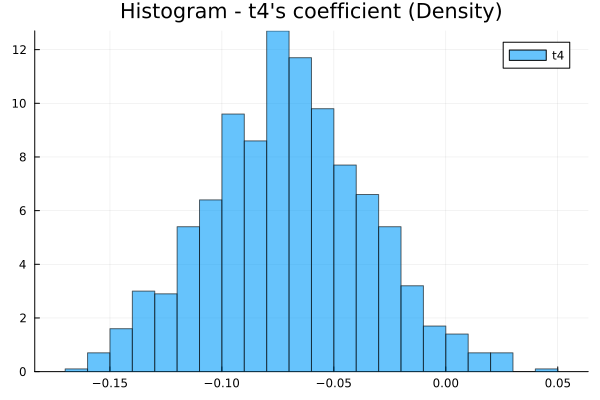

In [26]:
# Plotting the histograms
histogram(results[2], bins=20, title="Histogram - t4's coefficient (Density)", label="t4", alpha=0.6, normalize=true)

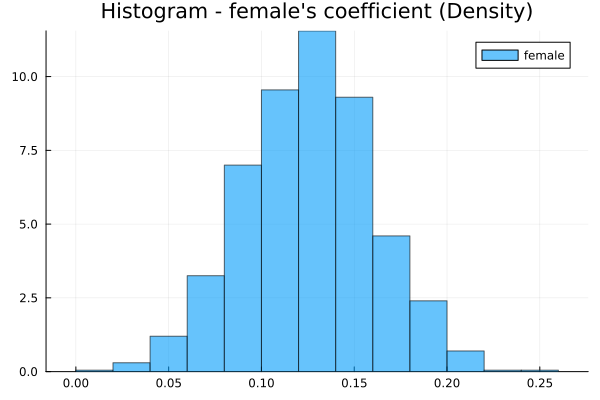

In [27]:
histogram(results[3], bins=20, title="Histogram - female's coefficient (Density)", label="female", alpha=0.6, normalize=true)

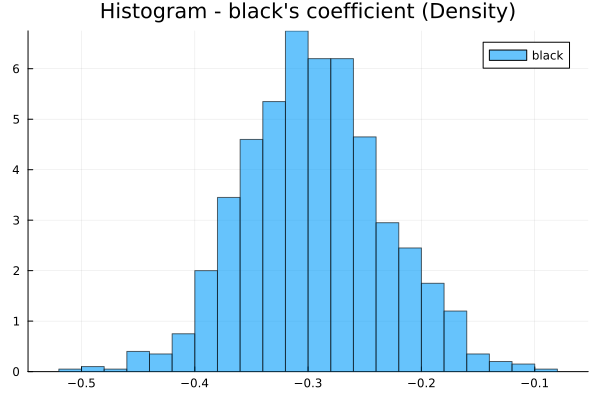

In [28]:
histogram(results[4], bins=20, title="Histogram - black's coefficient (Density)", label="black", alpha=0.6, normalize=true)